!pip install scikit-image

!pip install minisom

pip install pillow

In [3]:
import os
import numpy as np
from skimage import io, transform, color
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder
from minisom import MiniSom
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import zipfile

In [4]:
# extract features from heatmap images
def extract_features_from_image(image_path):
    img = Image.open(image_path).convert('L')  # сonvert to grayscale
    img_data = np.array(img)  # сonvert to numpy array
    feature = np.mean(img_data)  # уxtract mean intensity as feature (example)
    return feature

In [5]:
#here we need archived results of ""heatmap creation code.ipynb""
archive = zipfile.ZipFile('pictures.zip', 'r')

In [6]:
# extract features from each image
features=list(map(lambda x:extract_features_from_image(archive.open(archive.namelist()[x])),list(range(0,len(archive.namelist())))))

In [8]:
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(np.array(features).reshape(-1, 1))
normalized_features.shape

(28017, 1)

In [ ]:
# train SOM - find the best hyperparams
som_grid_rows = round(normalized_features.shape[0]**0.5)+1
som_grid_columns = round(normalized_features.shape[0]**0.5)+1
for s in [0.1,0.3,0.5]:
    for lr in [0.3,0.5,0.8]:
        som = MiniSom(som_grid_rows, som_grid_columns, normalized_features.shape[1], sigma=s, learning_rate=lr)
        som.random_weights_init(normalized_features)
        print(s,lr)
        som.train_batch(normalized_features, som_grid_rows*som_grid_columns, verbose=True)
        

In [10]:
s=0.1
lr=0.8
som = MiniSom(som_grid_rows, som_grid_columns, normalized_features.shape[1], sigma=s, learning_rate=lr)
som.random_weights_init(normalized_features)
print(s,lr)
som.train_batch(normalized_features, som_grid_rows*som_grid_columns, verbose=True)


0.1 0.8
 [ 28224 / 28224 ] 100% - 0:00:00 left 

/opt/conda/lib/python3.10/site-packages/minisom.py:540: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)



 quantization error: 6.819383816920668e-06


In [11]:
# clustering using MiniSom
cluster_labels = np.array([som.winner(f) for f in normalized_features])

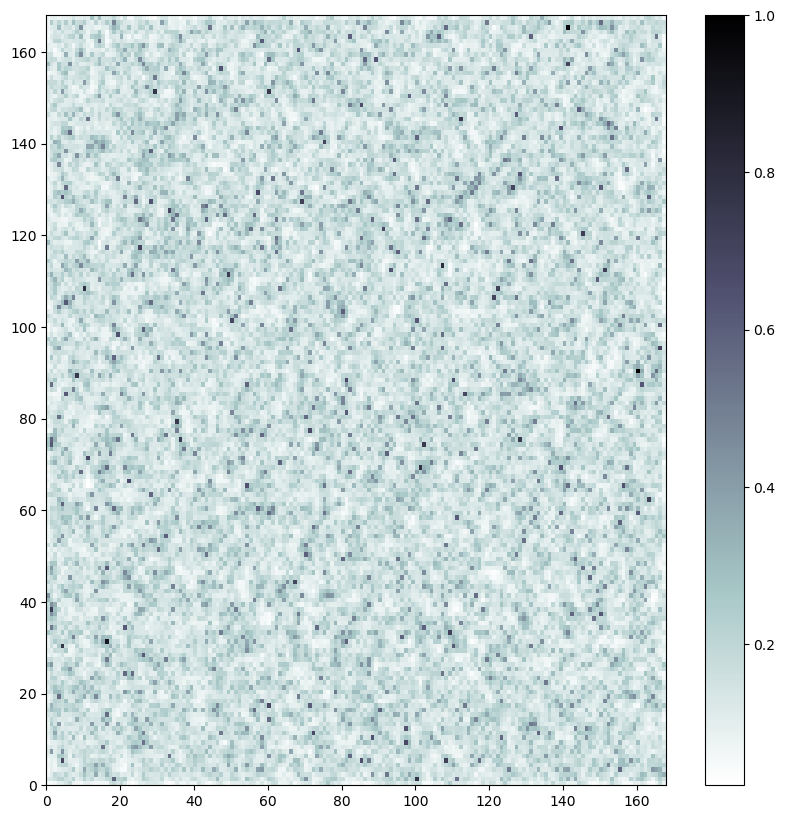

In [12]:
# Distance map
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

In [13]:
# OR assign clusters using K-Means on the SOM grid
som_weights = som.get_weights()
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(som_weights.reshape(-1, normalized_features.shape[1]))

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([5.429e+03, 9.415e+03, 7.306e+03, 3.692e+03, 1.568e+03, 5.390e+02,
        2.100e+02, 5.400e+01, 8.000e+00, 3.000e+00]),
 array([0.00170405, 0.10153364, 0.20136324, 0.30119283, 0.40102243,
        0.50085202, 0.60068162, 0.70051121, 0.80034081, 0.9001704 ,
        1.        ]),
 <BarContainer object of 10 artists>)

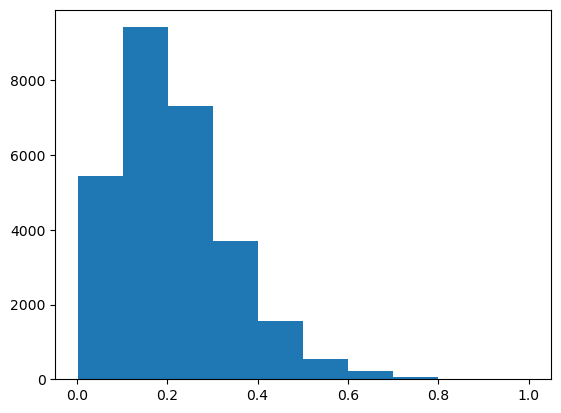

In [14]:
plt.hist(som_weights.reshape(-1, normalized_features.shape[1]))

In [15]:
som_weights.shape

(168, 168, 1)

In [16]:
import pandas as pd
def clusters_find(cluster_labels, normalized_features):
    clusters=[]
    for i, f in enumerate(normalized_features):
        clusters.append(cluster_labels[i])
    return clusters
cl=clusters_find(cluster_labels, normalized_features)
df=pd.DataFrame(cl,columns=['cluster_osm'])
df['id']=list(map(lambda x: int(str(x).split('/')[1].split('.')[0]),archive.namelist()))


In [17]:
df.head()

,cluster_osm,id
0,3,0
1,0,100
2,1,101
3,3,102
4,0,103079215104


In [18]:
#here we need the file after ""main file.ipynb""
tracks_ready=pd.read_csv('tracks_ready.csv',sep=',')


In [19]:
tracks_ready=pd.merge(tracks_ready,df,how='inner',on='id')

Text(0.5, 1.0, 'Number of customers inside each cluster')

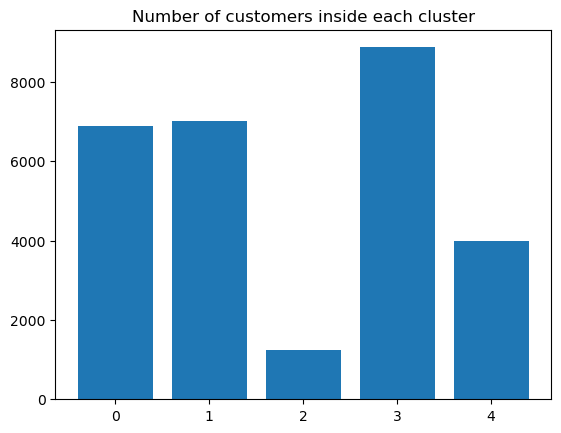

In [20]:
tracks_ready['help']=1
plt.bar(pd.pivot_table(tracks_ready.drop_duplicates('id'),index='cluster_osm',values='help',aggfunc=sum).reset_index()['cluster_osm'],
        pd.pivot_table(tracks_ready.drop_duplicates('id'),index='cluster_osm',values='help',aggfunc=sum).reset_index()['help'])
plt.title('Number of customers inside each cluster')

In [21]:
pd.pivot_table(tracks_ready.drop_duplicates('id'),index='cluster_osm',values='help',aggfunc=sum).reset_index()

,cluster_osm,help
0,0,6893
1,1,7004
2,2,1248
3,3,8873
4,4,3999


In [22]:
pd.pivot_table(tracks_ready[tracks_ready['cluster_osm']==1],index='final_part_of_day_in_word',columns='top5_avr',values='time_spent',aggfunc=sum)

top5_avr,0.0,1.0,2.0,3.0,4.0,5.0
final_part_of_day_in_word,,,,,,
evening,1.140386e+06,7.411857e+06,2.454467e+06,1.308508e+06,7.470474e+05,4.501135e+05
morning,9.688821e+05,2.790116e+06,1.198809e+06,7.813006e+05,5.055133e+05,3.217479e+05
night,7.171851e+05,2.956055e+06,1.503990e+06,9.671885e+05,5.822243e+05,3.493040e+05
whole day,3.129115e+05,3.871419e+06,9.887979e+05,4.563728e+05,2.452344e+05,1.718754e+05
whole day end,1.307130e+06,1.075978e+07,4.375767e+06,2.360319e+06,1.208493e+06,7.486927e+05
working hours,4.833130e+06,1.886171e+07,6.978515e+06,4.066924e+06,2.622925e+06,1.697118e+06


<AxesSubplot: xlabel='cluster_osm', ylabel='final_part_of_day_in_word'>

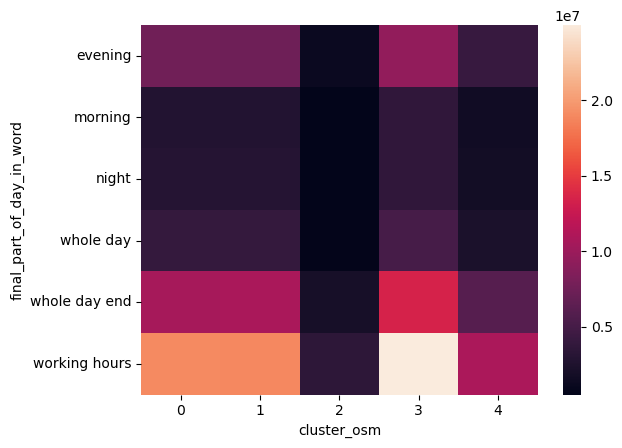

In [23]:
import seaborn as sns
sns.heatmap(pd.pivot_table(tracks_ready[tracks_ready['top5_avr']==1],index='final_part_of_day_in_word',columns='cluster_osm',values='time_spent',aggfunc=sum))

We want to create here average picture for each cluster

In [25]:
from PIL import Image

In [26]:
imgzip = zipfile.ZipFile("pictures.zip")
inflist = imgzip.infolist()
links=pd.DataFrame(inflist,columns=['link'])
links['id']=list(map(lambda f:int(str(f).split('/')[1].split('.')[0]),inflist))
links=pd.merge(links,df,how='left',on='id')
links.head(3)

,link,id,cluster_osm
0,<ZipInfo filename='ñ¿»½«¼/0.0.png' compress_ty...,0,3
1,<ZipInfo filename='ñ¿»½«¼/100.0.png' compress_...,100,0
2,<ZipInfo filename='ñ¿»½«¼/101.png' compress_ty...,101,1


99.98549252865226


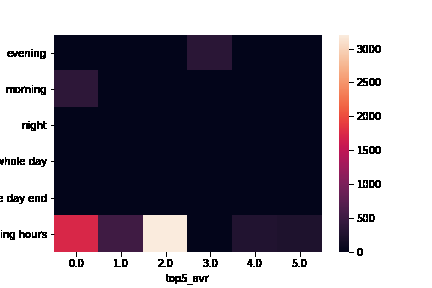

In [28]:
import zipfile
from PIL import Image
from IPython.display import clear_output


imgzip = zipfile.ZipFile("pictures.zip")
inflist = imgzip.infolist()
i=0
cluster_num=np.unique(links['cluster_osm'])
cl=cluster_num[0]
i=0
for f in links[links['cluster_osm']==cl]['link']:
    if i==0:

        ifile = imgzip.open(f)
        img = Image.open(ifile)
        img.putalpha(round(255/len(links[links['cluster_osm']==cl]['link'])))

    else:
        ifile = imgzip.open(f)
        img1 = Image.open(ifile)
        img1.putalpha(round(len(links[links['cluster_osm']==cl]['link'])))
        img=Image.alpha_composite(img, img1)


    clear_output(wait=True)
    print(i/len(links[links['cluster_osm']==cl]['link'])*100)
    i+=1

display(img)
    

99.98572244431753


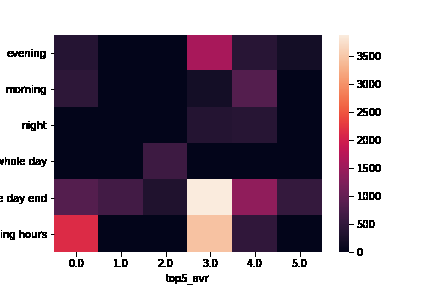

In [29]:
import zipfile
from PIL import Image
from IPython.display import clear_output


imgzip = zipfile.ZipFile("pictures.zip")
inflist = imgzip.infolist()
i=0
cluster_num=np.unique(links['cluster_osm'])
cl=cluster_num[1]
i=0
for f in links[links['cluster_osm']==cl]['link']:
    if i==0:

        ifile = imgzip.open(f)
        img = Image.open(ifile)
        img.putalpha(round(255/len(links[links['cluster_osm']==cl]['link'])))

    else:
        ifile = imgzip.open(f)
        img1 = Image.open(ifile)
        img1.putalpha(round(len(links[links['cluster_osm']==cl]['link'])))
        img=Image.alpha_composite(img, img1)


    clear_output(wait=True)
    print(i/len(links[links['cluster_osm']==cl]['link'])*100)
    i+=1

display(img)
    

99.9198717948718


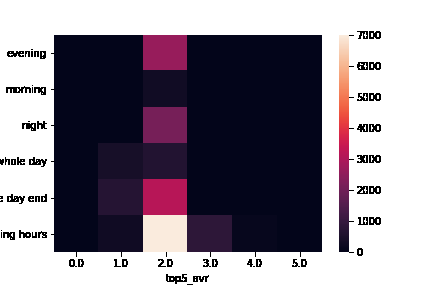

In [34]:
import zipfile
from PIL import Image
from IPython.display import clear_output


imgzip = zipfile.ZipFile("pictures.zip")
inflist = imgzip.infolist()
i=0
cluster_num=np.unique(links['cluster_osm'])
cl=cluster_num[2]
i=0
for f in links[links['cluster_osm']==cl]['link']:
    if i==0:

        ifile = imgzip.open(f)
        img = Image.open(ifile)
        img.putalpha(round(255/len(links[links['cluster_osm']==cl]['link'])))

    else:
        ifile = imgzip.open(f)
        img1 = Image.open(ifile)
        img1.putalpha(round(len(links[links['cluster_osm']==cl]['link'])))
        img=Image.alpha_composite(img, img1)


    clear_output(wait=True)
    print(i/len(links[links['cluster_osm']==cl]['link'])*100)
    i+=1

display(img)
    

99.98872985461512


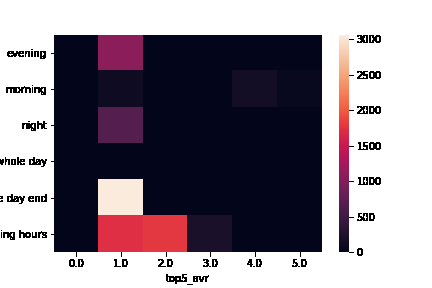

In [31]:
import zipfile
from PIL import Image
from IPython.display import clear_output


imgzip = zipfile.ZipFile("pictures.zip")
inflist = imgzip.infolist()
i=0
cluster_num=np.unique(links['cluster_osm'])
cl=cluster_num[3]
i=0
for f in links[links['cluster_osm']==cl]['link']:
    if i==0:

        ifile = imgzip.open(f)
        img = Image.open(ifile)
        img.putalpha(round(255/len(links[links['cluster_osm']==cl]['link'])))

    else:
        ifile = imgzip.open(f)
        img1 = Image.open(ifile)
        img1.putalpha(round(len(links[links['cluster_osm']==cl]['link'])))
        img=Image.alpha_composite(img, img1)


    clear_output(wait=True)
    print(i/len(links[links['cluster_osm']==cl]['link'])*100)
    i+=1

display(img)
    

99.97499374843711


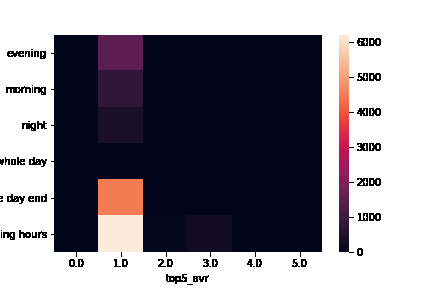

In [32]:
import zipfile
from PIL import Image
from IPython.display import clear_output


imgzip = zipfile.ZipFile("pictures.zip")
inflist = imgzip.infolist()
i=0
cluster_num=np.unique(links['cluster_osm'])
cl=cluster_num[4]
i=0
for f in links[links['cluster_osm']==cl]['link']:
    if i==0:

        ifile = imgzip.open(f)
        img = Image.open(ifile)
        img.putalpha(round(255/len(links[links['cluster_osm']==cl]['link'])))

    else:
        ifile = imgzip.open(f)
        img1 = Image.open(ifile)
        img1.putalpha(round(len(links[links['cluster_osm']==cl]['link'])))
        img=Image.alpha_composite(img, img1)


    clear_output(wait=True)
    print(i/len(links[links['cluster_osm']==cl]['link'])*100)
    i+=1

display(img)
    

In [33]:
df[df['cluster_osm']==0].sort_values(by='id')

,cluster_osm,id
27728,0,9
4058,0,20
7185,0,28
9414,0,34
11286,0,38
...,...,...
26717,0,764504179246
26724,0,773094113281
26739,0,773094113301
26745,0,773094113314
